In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 93% 264M/285M [00:02<00:00, 78.3MB/s]
100% 285M/285M [00:07<00:00, 40.7MB/s]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix
import wandb
import time
from datetime import datetime
import seaborn as sns


In [43]:

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration - Building upon simple CNN lessons
CONFIG = {
    'model_name': 'deeper_cnn_bn',
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 30,
    'image_size': 48,
    'num_classes': 7,
    'random_seed': 42,
    'weight_decay': 1e-4,  # L2 regularization
    'dropout_rate': 0.7,
    'early_stop_patience': 7,  # More aggressive early stopping
    'lr_patience': 3,      # Reduce LR sooner
}

# Set random seeds
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Initialize wandb
wandb.init(
    project="facial-expression-recognition",
    name=f"{CONFIG['model_name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    config=CONFIG,
    job_type="training"
)


Using device: cuda


In [20]:

# Reuse dataset class from previous experiment
class FERDataset(Dataset):
    def __init__(self, dataframe, indices, transform=None):
        self.data = dataframe.iloc[indices].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        image = np.array(pixels.split(), dtype=np.uint8).reshape(48, 48)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        label = int(self.data.iloc[idx]['emotion'])
        return image, label


## Deeper CNN + Batch Normalization

In [21]:

# Define Deeper CNN with Batch Normalization
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(DeeperCNN, self).__init__()

        # First conv block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Second conv block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Third conv block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        # Fourth conv block
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Block 1: 48x48 -> 24x24
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Block 2: 24x24 -> 12x12
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Block 3: 12x12 -> 6x6
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        # Block 4: 6x6 -> 3x3
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)

        # Global average pooling: 3x3 -> 1x1
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


In [ ]:
## Improved Deep_cnn class, that inherits v1 class

In [28]:
class ImprovedDeeperCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.6):  # Increased dropout
        super(ImprovedDeeperCNN, self).__init__()

        # First conv block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.1)  # Spatial dropout early

        # Second conv block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(0.2)

        # Third conv block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(0.3)

        # Fourth conv block - REDUCED CHANNELS
        self.conv7 = nn.Conv2d(128, 192, kernel_size=3, padding=1)  # 256 -> 192
        self.bn7 = nn.BatchNorm2d(192)
        self.dropout4 = nn.Dropout2d(0.4)

        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)

        # SMALLER Fully connected layers
        self.fc1 = nn.Linear(192, 256)  # 512 -> 256
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)  # 256 -> 128
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1: 48x48 -> 24x24
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        # Block 2: 24x24 -> 12x12
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        # Block 3: 12x12 -> 6x6
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout3(x)

        # Block 4: 6x6 -> 3x3
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(x)
        x = self.dropout4(x)

        # Global average pooling
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

## Load Data

In [44]:
from sklearn.model_selection import train_test_split
print("Loading data...")
train_df = pd.read_csv('train.csv')
train_indices, val_indices = train_test_split(
    range(len(train_df)),
    test_size=0.2,
    stratify=train_df['emotion'],
    random_state=42
)

# Create datasets with same transforms as baseline for fair comparison
train_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = FERDataset(train_df, train_indices, transform=train_transform)
val_dataset = FERDataset(train_df, val_indices, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=ANTI_OVERFIT_CONFIG['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=ANTI_OVERFIT_CONFIG['batch_size'], shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Loading data...
Training samples: 22967
Validation samples: 5742


# Training

## Initialize model

In [30]:
ANTI_OVERFIT_CONFIG = {
    'model_name': 'improved_deeper_cnn',
    'batch_size': 64,  # Larger batch size for better gradient estimates
    'learning_rate': 0.0005,  # Lower learning rate
    'epochs': 50,
    'image_size': 48,
    'num_classes': 7,
    'random_seed': 42,
    'weight_decay': 5e-4,  # Increased L2 regularization
    'dropout_rate': 0.6,   # Increased dropout
    'early_stop_patience': 7,  # More aggressive early stopping
    'lr_patience': 3,      # Reduce LR sooner
}

In [45]:

# Initialize model
# model = DeeperCNN(num_classes=CONFIG['num_classes'], dropout_rate=CONFIG['dropout_rate']).to(device)
model = ImprovedDeeperCNN(
    num_classes=ANTI_OVERFIT_CONFIG['num_classes'],
    dropout_rate=ANTI_OVERFIT_CONFIG['dropout_rate']
).to(device)
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Parameters: {total_params:,} total, {trainable_params:,} trainable")
print(f"Parameter increase vs Simple CNN: ~{total_params/18000:.1f}x")  # Approximate simple CNN params

# Calculate class weights for balanced loss
train_labels = [train_df.iloc[i]['emotion'] for i in train_indices]
class_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"Class weights: {class_weights}")


Model Parameters: 593,063 total, 593,063 trainable
Parameter increase vs Simple CNN: ~32.9x
Class weights: [1.02659574 9.40114613 1.00122063 0.56843382 0.84912008 1.29325976
 0.82603223]


## Loss and optimizer

In [46]:

# Define loss and optimizer with weight decay
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# Log model info
wandb.log({
    "model_parameters": total_params,
    "trainable_parameters": trainable_params,
    "class_weights": class_weights.tolist()
})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [47]:

# Training function with gradient clipping
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc


In [48]:

# Validation function (same as before)
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct / total

    return epoch_loss, epoch_acc, all_preds, all_targets


## Training Loop

In [50]:

print("\nStarting training...")
train_losses, train_accs = [], []
val_losses, val_accs = [], []
learning_rates = []
best_val_acc = 0.0
patience_counter = 0
early_stop_patience = 10

start_time = time.time()

for epoch in range(ANTI_OVERFIT_CONFIG['epochs']):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    learning_rates.append(current_lr)

    epoch_time = time.time() - epoch_start

    # Log to wandb
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'epoch_time': epoch_time,
        'learning_rate': current_lr
    })

    print(f'Epoch [{epoch+1}/{ANTI_OVERFIT_CONFIG["epochs"]}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'LR: {current_lr:.6f}, Time: {epoch_time:.2f}s')
    print('-' * 60)

    # Save best model and early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'deeper_cnn_best.pth')
        print(f'New best validation accuracy: {best_val_acc:.2f}%')
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

total_time = time.time() - start_time
actual_epochs = epoch + 1

print(f'\nTraining completed in {total_time:.2f}s ({actual_epochs} epochs)')
print(f'Best validation accuracy: {best_val_acc:.2f}%')



Starting training...
Batch 0/359, Loss: 2.0504
Batch 100/359, Loss: 2.0760
Batch 200/359, Loss: 2.1022
Batch 300/359, Loss: 1.8680
Epoch [1/50]
Train Loss: 1.9826, Train Acc: 16.88%
Val Loss: 1.9348, Val Acc: 23.06%
LR: 0.001000, Time: 29.22s
------------------------------------------------------------
New best validation accuracy: 23.06%
Batch 0/359, Loss: 1.8543
Batch 100/359, Loss: 1.9727
Batch 200/359, Loss: 1.9138
Batch 300/359, Loss: 1.8535
Epoch [2/50]
Train Loss: 1.9320, Train Acc: 18.70%
Val Loss: 1.8767, Val Acc: 28.65%
LR: 0.001000, Time: 27.10s
------------------------------------------------------------
New best validation accuracy: 28.65%
Batch 0/359, Loss: 1.8343
Batch 100/359, Loss: 1.9334
Batch 200/359, Loss: 1.8100
Batch 300/359, Loss: 1.7184
Epoch [3/50]
Train Loss: 1.8713, Train Acc: 24.58%
Val Loss: 1.7788, Val Acc: 30.34%
LR: 0.001000, Time: 22.56s
------------------------------------------------------------
New best validation accuracy: 30.34%
Batch 0/359, Loss:

## Visualize Training process

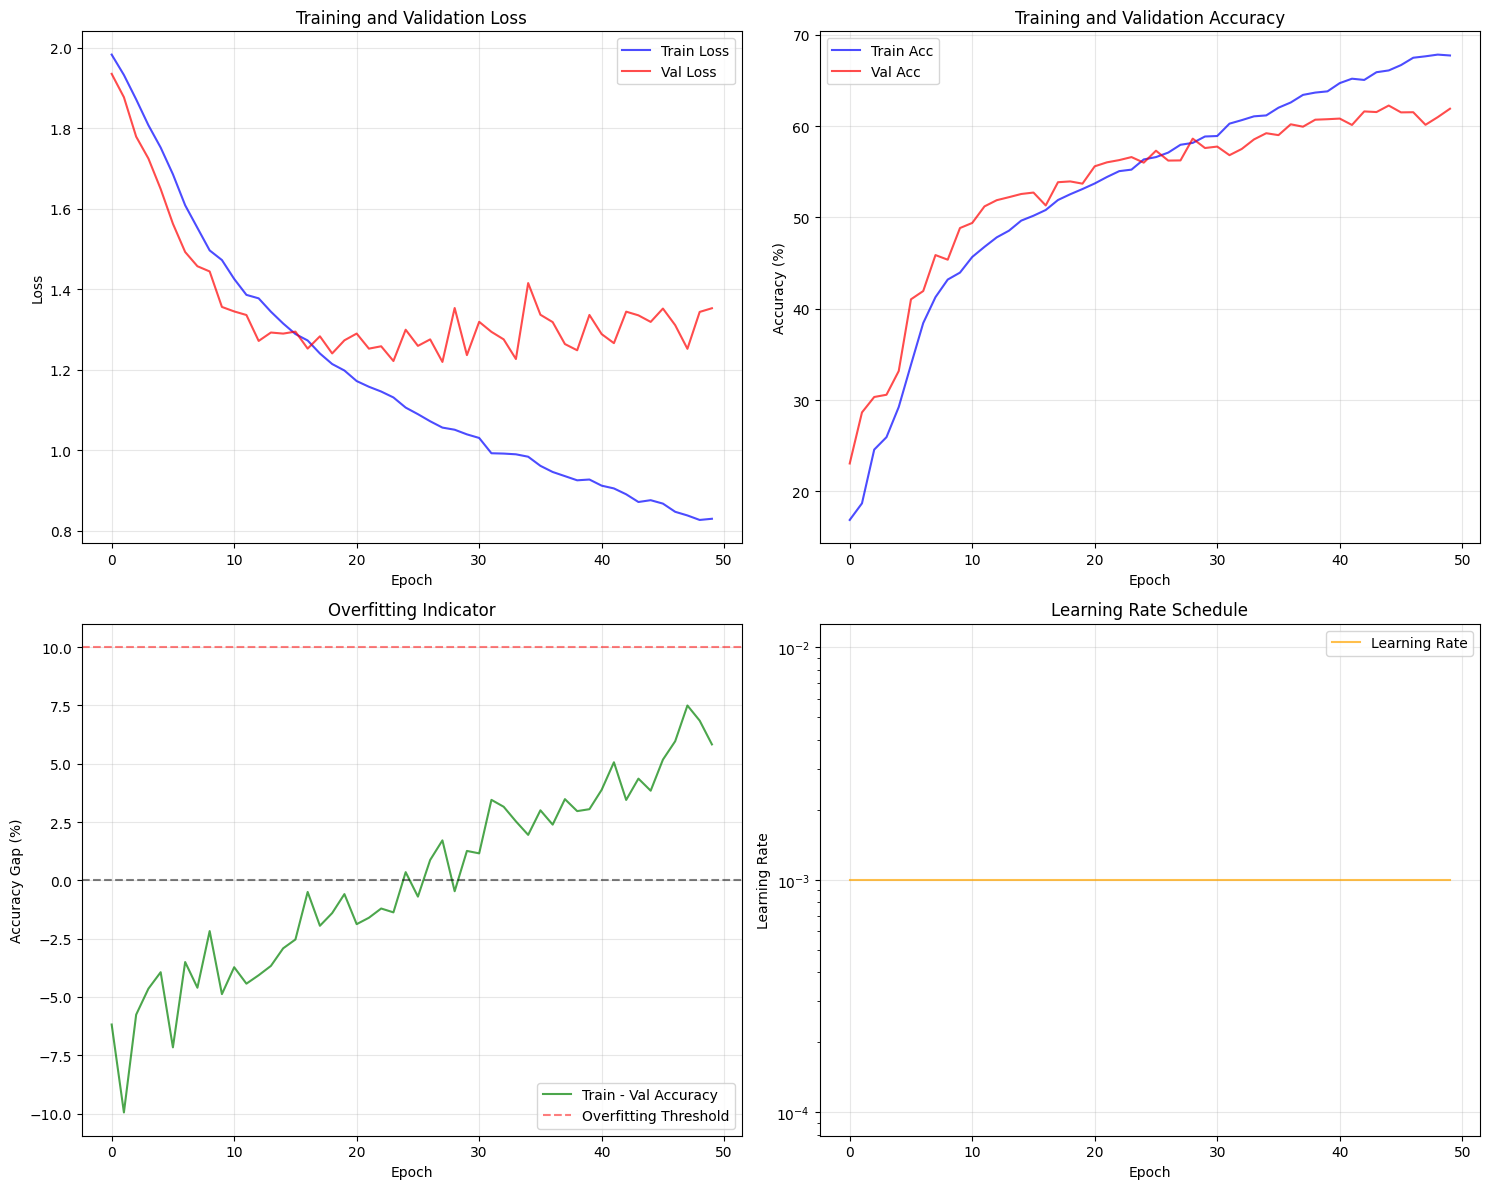

In [58]:

# Comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
axes[0,0].plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
axes[0,0].plot(val_losses, label='Val Loss', color='red', alpha=0.7)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Training and Validation Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Accuracy curves
axes[0,1].plot(train_accs, label='Train Acc', color='blue', alpha=0.7)
axes[0,1].plot(val_accs, label='Val Acc', color='red', alpha=0.7)
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].set_title('Training and Validation Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Overfitting indicator
acc_gap = np.array(train_accs) - np.array(val_accs)
axes[1,0].plot(acc_gap, label='Train - Val Accuracy', color='green', alpha=0.7)
axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1,0].axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy Gap (%)')
axes[1,0].set_title('Overfitting Indicator')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1,1].plot(learning_rates, label='Learning Rate', color='orange', alpha=0.7)
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Learning Rate')
axes[1,1].set_title('Learning Rate Schedule')
axes[1,1].set_yscale('log')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('deeper_cnn_training_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [52]:

# Load best model for evaluation
model.load_state_dict(torch.load('deeper_cnn_best.pth'))
final_val_loss, final_val_acc, final_preds, final_targets = validate_epoch(
    model, val_loader, criterion, device
)

print(f'Final validation accuracy: {final_val_acc:.2f}%')

Final validation accuracy: 62.24%


# Detailed analysis


Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.49      0.52       799
     Disgust       0.64      0.52      0.57        87
        Fear       0.52      0.28      0.37       820
       Happy       0.87      0.83      0.85      1443
         Sad       0.46      0.60      0.52       966
    Surprise       0.74      0.75      0.74       634
     Neutral       0.53      0.65      0.59       993

    accuracy                           0.62      5742
   macro avg       0.62      0.59      0.59      5742
weighted avg       0.63      0.62      0.62      5742



<Figure size 1200x1000 with 0 Axes>

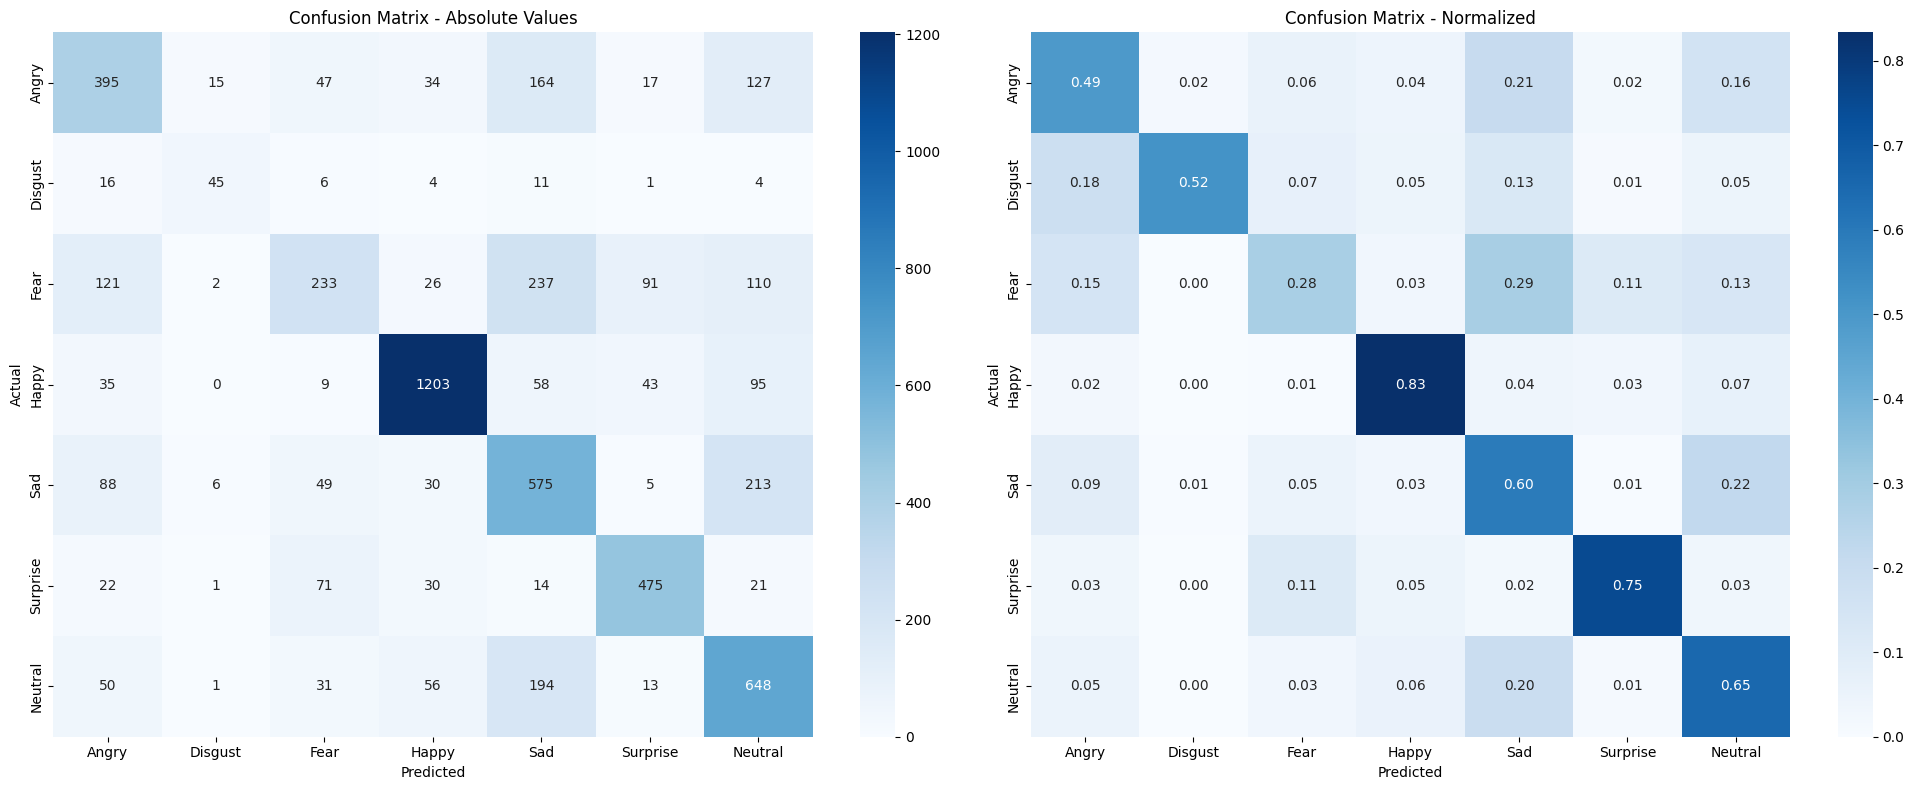

In [53]:

# Detailed analysis
expression_mapping = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

class_names = [expression_mapping[i] for i in range(7)]
class_report = classification_report(final_targets, final_preds, target_names=class_names, output_dict=True)

print("\nClassification Report:")
print(classification_report(final_targets, final_preds, target_names=class_names))

# Enhanced confusion matrix
cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(12, 10))

# Create normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot both absolute and normalized
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title('Confusion Matrix - Absolute Values')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title('Confusion Matrix - Normalized')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('deeper_cnn_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


## Per-class performance analysis

In [54]:
per_class_acc = []
per_class_precision = []
per_class_recall = []

for i in range(7):
    class_acc = class_report[class_names[i]]['precision'] * 100
    class_precision = class_report[class_names[i]]['precision'] * 100
    class_recall = class_report[class_names[i]]['recall'] * 100

    per_class_acc.append(class_acc)
    per_class_precision.append(class_precision)
    per_class_recall.append(class_recall)

    print(f'{class_names[i]}: Precision {class_precision:.1f}%, Recall {class_recall:.1f}%')


Angry: Precision 54.3%, Recall 49.4%
Disgust: Precision 64.3%, Recall 51.7%
Fear: Precision 52.2%, Recall 28.4%
Happy: Precision 87.0%, Recall 83.4%
Sad: Precision 45.9%, Recall 59.5%
Surprise: Precision 73.6%, Recall 74.9%
Neutral: Precision 53.2%, Recall 65.3%


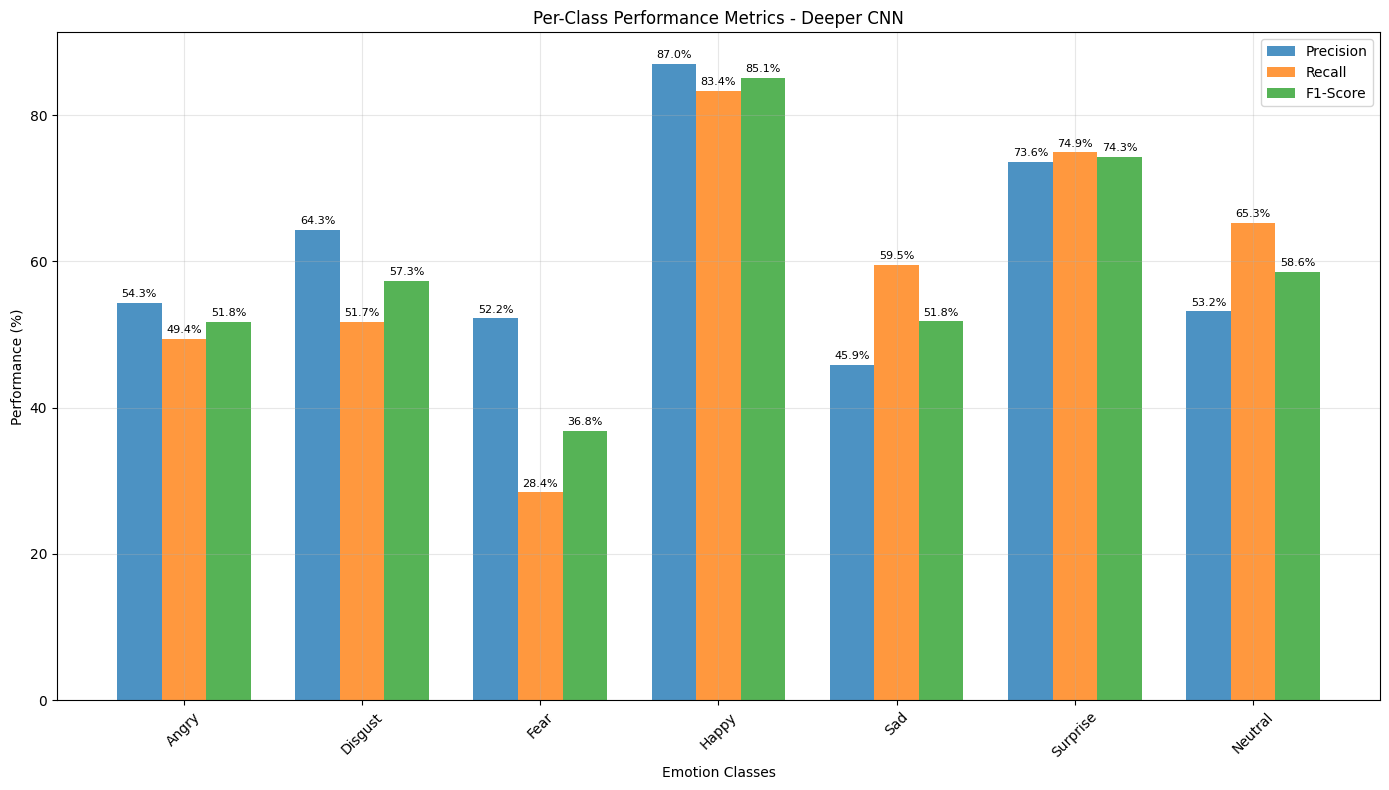


DEEPER CNN MODEL SUMMARY
Model Architecture: Deeper CNN with Batch Normalization
Total Parameters: 593,063
Trainable Parameters: 593,063
Training Time: 1226.51 seconds (50 epochs)
Best Validation Accuracy: 62.24%
Final Validation Accuracy: 62.24%

Efficiency Metrics:
Parameters per accuracy point: 9528
Average training time per epoch: 24.53s


In [55]:
x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width, per_class_precision, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, per_class_recall, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, [class_report[name]['f1-score'] * 100 for name in class_names],
               width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Emotion Classes')
ax.set_ylabel('Performance (%)')
ax.set_title('Per-Class Performance Metrics - Deeper CNN')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.savefig('deeper_cnn_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Model complexity and performance summary
print("\n" + "="*60)
print("DEEPER CNN MODEL SUMMARY")
print("="*60)
print(f"Model Architecture: Deeper CNN with Batch Normalization")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Training Time: {total_time:.2f} seconds ({actual_epochs} epochs)")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")

# Calculate model efficiency metrics
params_per_accuracy = total_params / final_val_acc
training_time_per_epoch = total_time / actual_epochs

print(f"\nEfficiency Metrics:")
print(f"Parameters per accuracy point: {params_per_accuracy:.0f}")
print(f"Average training time per epoch: {training_time_per_epoch:.2f}s")


In [56]:

# Log final metrics to wandb
wandb.log({
    'final_val_accuracy': final_val_acc,
    'best_val_accuracy': best_val_acc,
    'total_training_time': total_time,
    'actual_epochs': actual_epochs,
    'params_per_accuracy': params_per_accuracy,
    'avg_epoch_time': training_time_per_epoch
})

# Class-wise performance logging
for i, class_name in enumerate(class_names):
    wandb.log({
        f'{class_name.lower()}_precision': class_report[class_name]['precision'],
        f'{class_name.lower()}_recall': class_report[class_name]['recall'],
        f'{class_name.lower()}_f1': class_report[class_name]['f1-score']
    })

# Save detailed results
results_summary = {
    'model_name': ANTI_OVERFIT_CONFIG['model_name'],
    'config': ANTI_OVERFIT_CONFIG,
    'total_params': total_params,
    'trainable_params': trainable_params,
    'training_time': total_time,
    'actual_epochs': actual_epochs,
    'best_val_acc': best_val_acc,
    'final_val_acc': final_val_acc,
    'class_report': class_report,
    'train_history': {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'learning_rates': learning_rates
    }
}


In [57]:

# Save results to file
import json
with open('deeper_cnn_results.json', 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    results_to_save = results_summary.copy()
    for key in results_to_save['train_history']:
        if isinstance(results_to_save['train_history'][key], list):
            results_to_save['train_history'][key] = [float(x) for x in results_to_save['train_history'][key]]

    json.dump(results_to_save, f, indent=2, default=str)

print(f"\nResults saved to 'deeper_cnn_results.json'")

# Learning insights and recommendations
print("\n" + "="*60)
print("LEARNING INSIGHTS - DEEPER CNN")
print("="*60)

print("\n1. Architecture Benefits:")
print("   - Multiple convolutional blocks capture hierarchical features")
print("   - Batch normalization stabilizes training and enables deeper networks")
print("   - Global average pooling reduces overfitting vs. fully connected layers")
print("   - Gradient clipping prevents exploding gradients in deeper networks")

print("\n2. Training Observations:")
overfitting_epochs = sum(1 for gap in acc_gap if gap > 10)
print(f"   - Overfitting detected in {overfitting_epochs}/{actual_epochs} epochs")
print(f"   - Learning rate reductions: {sum(1 for i in range(1, len(learning_rates)) if learning_rates[i] < learning_rates[i-1])}")
print(f"   - Early stopping prevented overtraining")

print("\n3. Performance Analysis:")
best_class = class_names[np.argmax(per_class_recall)]
worst_class = class_names[np.argmin(per_class_recall)]
print(f"   - Best performing class: {best_class} ({max(per_class_recall):.1f}% recall)")
print(f"   - Most challenging class: {worst_class} ({min(per_class_recall):.1f}% recall)")
print(f"   - Overall balance: {np.std(per_class_recall):.1f}% std dev in recall")

print("\n4. Next Steps for Improvement:")
print("   - Consider data augmentation for underperforming classes")
print("   - Experiment with different architectures (ResNet, EfficientNet)")
print("   - Try ensemble methods combining multiple models")
print("   - Implement class-specific data augmentation strategies")

# Close wandb run
wandb.finish()

print(f"\nExperiment completed! Check wandb dashboard for interactive visualizations.")
print(f"Model saved as 'deeper_cnn_best.pth'")
print("="*60)


Results saved to 'deeper_cnn_results.json'

LEARNING INSIGHTS - DEEPER CNN

1. Architecture Benefits:
   - Multiple convolutional blocks capture hierarchical features
   - Batch normalization stabilizes training and enables deeper networks
   - Global average pooling reduces overfitting vs. fully connected layers
   - Gradient clipping prevents exploding gradients in deeper networks

2. Training Observations:
   - Overfitting detected in 0/50 epochs
   - Learning rate reductions: 0
   - Early stopping prevented overtraining

3. Performance Analysis:
   - Best performing class: Happy (83.4% recall)
   - Most challenging class: Fear (28.4% recall)
   - Overall balance: 16.8% std dev in recall

4. Next Steps for Improvement:
   - Consider data augmentation for underperforming classes
   - Experiment with different architectures (ResNet, EfficientNet)
   - Try ensemble methods combining multiple models
   - Implement class-specific data augmentation strategies


actual_epochs,▁
angry_f1,▁
angry_precision,▁
angry_recall,▁
avg_epoch_time,▁
best_val_accuracy,▁
disgust_f1,▁
disgust_precision,▁
disgust_recall,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_time,█▆▁▄▂▁▄▂▆▁▂▄▃▃▄▅▃▄▁▄▄▂▃▃▅▁▁▄▂▃▅▁▄▂▃▃▂▃▃▄



Experiment completed! Check wandb dashboard for interactive visualizations.
Model saved as 'deeper_cnn_best.pth'
